In [307]:
import numpy as np
import os
import re
import seaborn as sns

from itertools import product
from sklearn.cluster import KMeans
from tqdm.notebook import tqdm

In [115]:
# Load the data
data_dir = "../data/AAMAS"
dset_idx = 1
which_dset = "00037-0000000%d.cat" % dset_idx

dset_sizes = [(201, 613), (161, 442), (667, 526)]
# Yes, maybe, no answer, no
rating_scores = [1.0, .5, 0.0, -1.0]

if dset_idx == 3:
    # Yes, maybe, no, conflict
    rating_scores = [1.0, .5, -1.0, 0.0]

agent_idx = 0
with open(os.path.join(data_dir, which_dset)) as f:
    ratings = np.zeros(dset_sizes[dset_idx-1])
    for l in f.readlines():
        if not l.startswith("#"):
            l = re.sub("[0-9]*: ", "", l)
            bracket_list = re.compile("\{[0-9, ]*\}|[0-9]+")
            lists = bracket_list.findall(l)
            if len(lists) != 4:
                print(lists)
                print(l)
                print("PROBLEM")
            for idx, list_of_prefs in enumerate(lists):
                if list_of_prefs != '{}':
                    list_of_prefs = re.sub("[\{\}]", "", list_of_prefs)
                    prefs = [int(x)-1 for x in list_of_prefs.split(",")]
                    ratings[agent_idx, prefs] = rating_scores[idx]
            agent_idx += 1

In [79]:
np.save(os.path.join(data_dir, "ratings_%d.npy" % dset_idx), ratings)

In [80]:
# Use https://dl.acm.org/doi/pdf/10.1145/1553374.1553452 to get prob model for CVaR objectives
gen = np.random.default_rng(seed=0)
q = 20
x = gen.normal(loc=0, scale=1e-3, size=(ratings.shape[0], q))
sig = .05

In [81]:
x

array([[ 1.25730221e-04, -1.32104863e-04,  6.40422650e-04, ...,
        -3.16300156e-04,  4.11630536e-04,  1.04251337e-03],
       [-1.28534663e-04,  1.36646347e-03, -6.65194673e-04, ...,
        -1.29613634e-04,  7.83975470e-04,  1.49343115e-03],
       [-1.25906553e-03,  1.51392377e-03,  1.34587542e-03, ...,
         6.96042724e-04, -1.18411797e-03, -6.61702572e-04],
       ...,
       [-9.02690927e-04,  9.37403974e-04,  9.56067063e-04, ...,
         1.11817382e-03, -1.54199682e-04,  2.54180358e-05],
       [ 2.62712982e-04,  2.24919949e-04,  8.63618968e-05, ...,
         4.42117853e-04,  9.69861933e-04, -1.11241352e-03],
       [-7.35110772e-04, -5.93191918e-04,  1.13752576e-04, ...,
        -7.00356874e-04, -4.90968554e-04, -1.48581079e-03]])

In [82]:
n_iter = 100

lr = 1e-4

for i in tqdm(range(n_iter)):
#     item_idx = gen.integers(ratings.shape[1])
    for item_idx in range(ratings.shape[1]):
        # pick out the users where this item was rated
        observed = np.where(np.abs(ratings[:, item_idx]) > 1e-4)[0]
#         print(observed)
#         print(x[observed])
        if len(observed):
            Cj = np.matmul(x[observed], x[observed].T) + (sig**2)*np.eye(len(observed))
#             print(Cj)
            Cinv = np.linalg.inv(Cj)
            yobs = ratings[observed, item_idx]
    #         print(yobs)
            G = np.outer(yobs, yobs)
            G = np.matmul(Cinv, G)
            G = np.matmul(G, Cinv)
            G -= Cinv
            grad = np.matmul(-G, x[observed])

            x[observed] -= lr*grad

  0%|          | 0/100 [00:00<?, ?it/s]

In [83]:
# For each item, we can sample the rating for each user. It is by section 3.1, the prediction of user rating section.
print(x.shape)
k = np.matmul(x, x.T)
s = k + (sig**2)*np.eye(k.shape[0])
mu_matrix = np.zeros(ratings.shape)
zeta_matrix = np.zeros(ratings.shape)
for item_idx in tqdm(range(ratings.shape[1])):
    for user_idx in range(ratings.shape[0]):
        observed = np.where(np.abs(ratings[:, item_idx]) > 1e-4)[0]
        sobs = s[observed, :][:, observed]
        final_s = np.matmul(np.linalg.inv(sobs), k[observed, user_idx])
        mu = np.dot(final_s, ratings[observed, item_idx])
        mu_matrix[user_idx, item_idx] = mu
        zeta_matrix[user_idx, item_idx] = k[user_idx, user_idx] + sig**2 - np.dot(k[observed, user_idx], final_s)
        
# cov_mat = np.matmul(x, x.T) + (sig**2)*np.eye(x.shape[0])
# zero_vec = np.zeros(x.shape[0])

(667, 20)


  0%|          | 0/526 [00:00<?, ?it/s]

In [84]:
np.save(os.path.join(data_dir, "mu_matrix_%d.npy" % dset_idx), mu_matrix)
np.save(os.path.join(data_dir, "zeta_matrix_%d.npy" % dset_idx), zeta_matrix)

In [93]:
ratings[np.where(ratings > .5)].shape

(6665,)

In [94]:
mu_matrix[np.where(ratings == 1)][:300]

array([-7.82595666e-01, -9.49701474e-01, -8.63080155e-01, -7.11956223e-01,
       -6.62208094e-01, -5.55182234e-01,  3.65711030e-01,  6.88942575e-01,
        1.31609686e-01, -7.93921557e-01,  3.11553308e-01,  4.97713798e-01,
        6.16549406e-01, -5.88141446e-01,  7.99683303e-01, -4.09261306e-01,
       -3.58425982e-01, -1.44308933e-01, -7.85643181e-01,  9.15239815e-01,
        4.12078698e-01,  8.53442885e-01,  1.45487714e-01,  1.38522053e-01,
        1.12499062e+00, -5.72806046e-01,  6.43900552e-01, -4.78208311e-01,
       -2.08070794e-01, -5.61838505e-01, -5.11127539e-01, -4.26639376e-01,
        2.71069772e-01,  8.73428142e-01, -1.30637189e-01,  1.10271852e+00,
       -2.54017071e-01, -5.12118856e-01,  4.39566798e-02,  1.23874228e+00,
       -1.71406061e-01, -3.12844073e-01,  1.07128820e+00,  1.04576835e+00,
       -1.97453317e-01,  1.59088408e-01,  3.70741113e-01,  8.84302374e-01,
       -3.36355965e-01,  1.99348149e+00,  1.89502857e+00,  2.76547596e-01,
        7.80480377e-01, -

<Axes: ylabel='Count'>

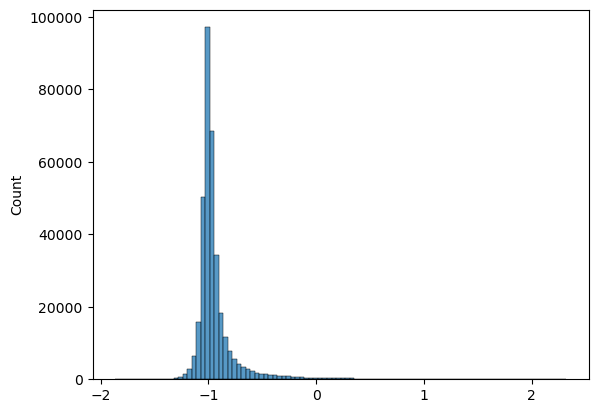

In [87]:
sns.histplot(mu_matrix.flatten(), bins=100)

<Axes: ylabel='Count'>

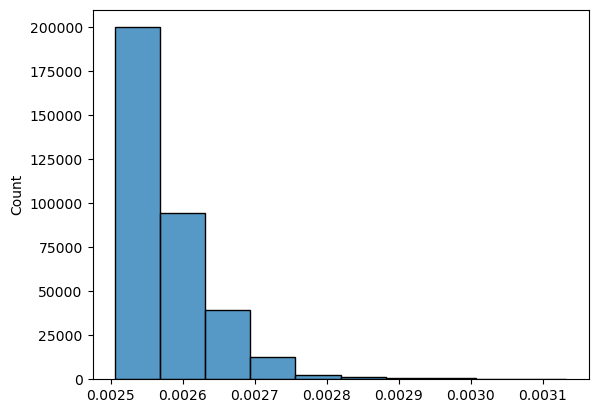

In [88]:
sns.histplot(zeta_matrix.flatten(), bins=10)

In [89]:
np.max(zeta_matrix, axis=0)

array([0.00296505, 0.00296334, 0.00296435, 0.00295996, 0.00295934,
       0.00296299, 0.00295931, 0.0029594 , 0.00296597, 0.00297264,
       0.00295932, 0.00296923, 0.00296814, 0.00295931, 0.00296012,
       0.00295932, 0.00296251, 0.00295974, 0.00296325, 0.00297145,
       0.00295931, 0.0030498 , 0.00295968, 0.00295931, 0.00297273,
       0.00295999, 0.00295989, 0.00296557, 0.0029594 , 0.00306311,
       0.00296902, 0.00296407, 0.00295937, 0.0029602 , 0.00296237,
       0.00296058, 0.00295931, 0.00295931, 0.00295931, 0.00295955,
       0.0029636 , 0.00295938, 0.00295931, 0.00296003, 0.00296141,
       0.00296319, 0.00296025, 0.00296027, 0.00296245, 0.00296156,
       0.00295938, 0.00296021, 0.00296334, 0.00295934, 0.00295954,
       0.00296074, 0.00295932, 0.00295931, 0.00296271, 0.00310144,
       0.00296818, 0.00295972, 0.00296031, 0.00295961, 0.00295976,
       0.00296168, 0.00295946, 0.00295964, 0.00295935, 0.0029677 ,
       0.0029684 , 0.00295998, 0.00296061, 0.00296353, 0.00297

# Now we'll cluster these and make groups for both getting COIs and for the GESW

In [436]:
# cluster ratings
dset_idx = 3
ratings = np.load(os.path.join(data_dir, "ratings_%d.npy" % dset_idx))

ratings

array([[-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.],
       ...,
       [-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1.,  1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.]])

<Axes: ylabel='Count'>

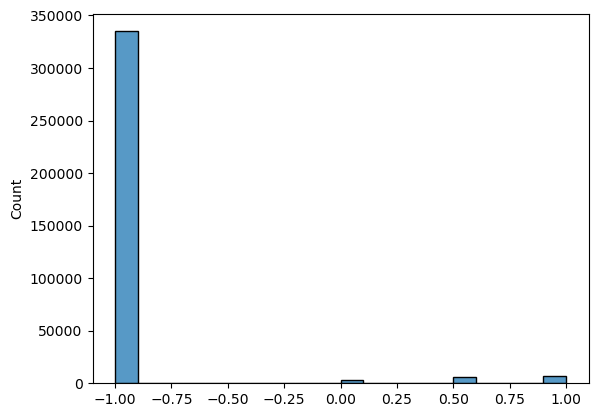

In [437]:
sns.histplot(ratings.flatten())

In [390]:
from sklearn.cluster import SpectralBiclustering, KMeans
from scipy.spatial.distance import cdist
# clustering = SpectralBiclustering(n_clusters=4, random_state=1, method="log").fit(ratings)

In [391]:
k = 4
min_cluster_size = ratings.shape[0]//(k+1)
print(min_cluster_size)

row_clusters = KMeans(n_clusters=4, random_state=0).fit(ratings)
row_centers = row_clusters.cluster_centers_
distance_matrix = cdist(ratings, row_centers)
print(distance_matrix.shape)
# Now match each row to a column such that the total number of rows matching to columns is roughly equal.
import gurobipy as gp
m = gp.Model()

matching = m.addMVar(distance_matrix.shape, vtype=gp.GRB.BINARY)
m.addConstr(matching.sum(axis=1) == 1)
m.addConstr(matching.sum(axis=0) >= min_cluster_size)

obj = (matching*distance_matrix).sum()

m.setObjective(obj)
m.optimize()

row_clusters = np.where(matching.x)[1]

133
(667, 4)
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 671 rows, 2668 columns and 5336 nonzeros
Model fingerprint: 0x3a919a9e
Variable types: 0 continuous, 2668 integer (2668 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e+00, 2e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+02]
Found heuristic solution: objective 5782.0563291
Presolve time: 0.02s
Presolved: 671 rows, 2668 columns, 5336 nonzeros
Variable types: 0 continuous, 2668 integer (2668 binary)
Found heuristic solution: objective 5405.9146928

Root relaxation: objective 4.970396e+03, 972 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/N

In [392]:
# Do the same for the columns
k = 4
min_cluster_size = ratings.shape[1]//(k+1)
print(min_cluster_size)

col_clusters = KMeans(n_clusters=4, random_state=0).fit(ratings.T)
col_centers = col_clusters.cluster_centers_
distance_matrix = cdist(ratings.T, col_centers)
print(distance_matrix.shape)
# Now match each row to a column such that the total number of rows matching to columns is roughly equal.
import gurobipy as gp
m = gp.Model()

matching = m.addMVar(distance_matrix.shape, vtype=gp.GRB.BINARY)
m.addConstr(matching.sum(axis=1) == 1)
m.addConstr(matching.sum(axis=0) >= min_cluster_size)

obj = (matching*distance_matrix).sum()

m.setObjective(obj)
m.optimize()

col_clusters = np.where(matching.x)[1]

105
(526, 4)
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 530 rows, 2104 columns and 4208 nonzeros
Model fingerprint: 0xe6f3e31b
Variable types: 0 continuous, 2104 integer (2104 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e+00, 2e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+02]
Found heuristic solution: objective 5382.4332668
Presolve time: 0.01s
Presolved: 530 rows, 2104 columns, 4208 nonzeros
Variable types: 0 continuous, 2104 integer (2104 binary)
Found heuristic solution: objective 4943.1623742

Root relaxation: objective 4.601444e+03, 711 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/N

In [393]:
Counter(row_clusters)

Counter({1: 133, 2: 133, 0: 268, 3: 133})

In [394]:
Counter(col_clusters)

Counter({2: 105, 1: 105, 3: 211, 0: 105})

In [395]:
# Match up the row clusters with the column clusters. 
# For each pair of clusters, we take the submatrix corresponding to those rows and columns. We can then
# compute the average similarity. Then compute a maximum matching basically.
cluster_link_scores = np.zeros((k,k))
for ridx, cidx in product(range(k), range(k)):
    cluster_link_scores[ridx, cidx] = np.mean(ratings[row_clusters == ridx, :][:, col_clusters == cidx])
print(cluster_link_scores)

[[-0.98798863 -0.92800284 -0.95520611 -0.95800912]
 [-0.7075546  -0.96616541 -0.95363409 -0.95200086]
 [-0.9660222  -0.93161475 -0.7868242  -0.95061112]
 [-0.98191908 -0.77382743 -0.79817401 -0.96142608]]


In [396]:
from scipy.optimize import linear_sum_assignment
row_ind, col_ind = linear_sum_assignment(-1*cluster_link_scores)

In [397]:
print(row_ind, col_ind)

[0 1 2 3] [3 0 2 1]


In [398]:
new_col_inds = row_ind[np.argsort(col_ind)]

In [399]:
remapped_col_clusters = [new_col_inds[i] for i in col_clusters]

In [400]:
Counter(remapped_col_clusters)

Counter({2: 105, 3: 105, 0: 211, 1: 105})

In [401]:
np.sum(ratings[:, 13] > .5)

21

In [402]:
ratings.shape

(667, 526)

In [403]:
np.save(os.path.join(data_dir, "groups_%d.npy" % dset_idx), remapped_col_clusters)

In [404]:
coi_mask = (np.reshape(remapped_col_clusters, (1,-1)) == np.reshape(row_clusters, (-1, 1))).astype(int)

In [405]:
np.sum(coi_mask)/coi_mask.size

0.28059069324653263

In [406]:
# np.sum(coi_mask, axis=0)

In [407]:
print(data_dir)

../data/AAMAS


In [408]:
np.save(os.path.join(data_dir, "coi_mask_%d.npy" % dset_idx), coi_mask)

In [412]:
import gurobipy as gp
m = gp.Model("TPMS")

mu_matrix = np.load("../data/AAMAS/mu_matrix_%d.npy" % dset_idx)
coi_mask = np.load("../data/AAMAS/coi_mask_%d.npy" % dset_idx)

cs = [3, 2, 2]
ls = [15, 15, 4]
covs_lb = cs[dset_idx-1] * np.ones(mu_matrix.shape[1])
covs_ub = covs_lb
loads = ls[dset_idx - 1] * np.ones(mu_matrix.shape[0])

covs_lb = np.minimum(covs_lb, np.sum(coi_mask, axis=0))


alloc = m.addMVar(mu_matrix.shape, vtype=gp.GRB.BINARY, name='alloc')

m.addConstr(alloc.sum(axis=0) >= covs_lb)
m.addConstr(alloc.sum(axis=0) <= covs_ub)
m.addConstr(alloc.sum(axis=1) <= loads)
m.addConstr(alloc <= coi_mask)

obj = (alloc*mu_matrix).sum()
m.setObjective(obj, gp.GRB.MAXIMIZE)

m.optimize()

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 352561 rows, 350842 columns and 1403368 nonzeros
Model fingerprint: 0x291b64d3
Variable types: 0 continuous, 350842 integer (350842 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e-05, 2e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 4e+00]
Found heuristic solution: objective -890.3243179
Presolve removed 352082 rows and 294294 columns
Presolve time: 0.99s
Presolved: 479 rows, 56548 columns, 113096 nonzeros
Found heuristic solution: objective -216.0878651
Variable types: 0 continuous, 56548 integer (56548 binary)
Found heuristic solution: objective -187.9824425

Root relaxation: objective -1.249874e+02, 772 iterations, 0.04 seconds (0.03 work units)

    Nodes    |    Current Node    |    

In [413]:
# np.sum(coi_mask, axis=0)
np.sum(alloc.x, axis=1)

array([0., 4., 4., 3., 2., 0., 4., 1., 4., 3., 0., 4., 4., 0., 0., 4., 4.,
       0., 0., 0., 4., 1., 0., 4., 0., 4., 0., 4., 1., 4., 4., 4., 0., 4.,
       4., 2., 4., 4., 4., 0., 2., 2., 4., 4., 0., 0., 4., 4., 4., 4., 4.,
       4., 4., 2., 4., 4., 4., 3., 4., 4., 4., 4., 4., 4., 4., 3., 4., 0.,
       4., 4., 4., 0., 0., 4., 0., 0., 0., 0., 4., 0., 0., 4., 0., 0., 0.,
       0., 3., 4., 0., 0., 1., 0., 1., 0., 0., 4., 4., 0., 0., 4., 0., 4.,
       0., 4., 4., 0., 0., 0., 0., 2., 0., 0., 0., 1., 2., 1., 0., 4., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 4., 0., 4., 3., 0., 4., 4., 4.,
       0., 4., 0., 0., 4., 4., 4., 0., 0., 0., 0., 0., 4., 0., 4., 1., 0.,
       4., 0., 4., 0., 2., 4., 0., 4., 4., 2., 0., 4., 0., 0., 4., 0., 4.,
       0., 4., 0., 0., 4., 4., 4., 0., 4., 0., 0., 0., 0., 4., 0., 0., 4.,
       4., 0., 0., 4., 4., 0., 0., 4., 0., 3., 0., 1., 3., 0., 4., 1., 4.,
       1., 0., 4., 4., 0., 1., 4., 3., 0., 0., 4., 4., 4., 0., 0., 0., 1.,
       4., 0., 0., 0., 4.

In [414]:
np.sum(coi_mask, axis=0)[:30]

array([133, 133, 268, 268, 133, 133, 268, 268, 133, 268, 268, 133, 133,
       133, 133, 268, 133, 133, 268, 268, 268, 268, 268, 133, 133, 133,
       268, 133, 268, 133])

In [416]:
np.sum(mu_matrix > 0)

4629

In [430]:
(alloc.x*mu_matrix)[np.where(alloc.x > .5)][:50]

array([ 0.7996833 ,  0.83835331,  1.12499062,  0.8914211 , -0.78597412,
       -0.73600691, -0.80784617, -0.84445602, -0.87994646, -0.51211886,
       -0.89839996,  0.30609427,  0.49783666,  0.15539555,  0.45517362,
       -0.03782739,  0.13930814,  0.76662682, -0.05363163,  0.15707378,
       -0.64195638,  0.61690283, -0.92971344, -0.87478012, -0.90458152,
        0.77843746,  0.53877998,  0.89484714,  1.08641038, -0.0951319 ,
        0.61434734,  0.44087165,  0.98100219,  0.73363947,  0.37858621,
        0.01480599,  0.43697855,  0.19224157,  0.13540374, -0.11962357,
        0.96458317,  0.9670202 ,  0.98330062,  1.91395501,  1.66754085,
       -0.72756361, -0.01379574, -0.18888704, -0.24075622, -0.24784361])

In [424]:
alloc.x[np.where(alloc.x > .5)]

array([1., 1., 1., ..., 1., 1., 1.])

<Axes: ylabel='Count'>

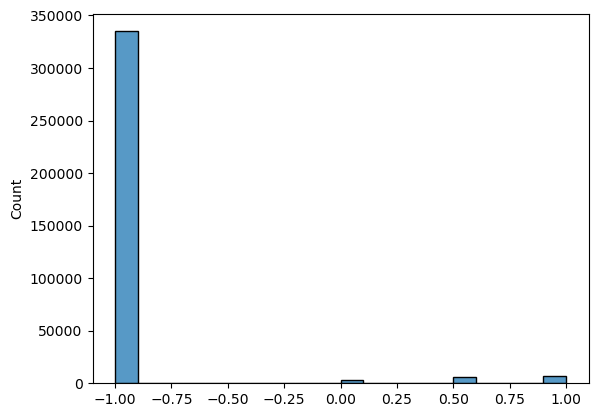

In [431]:
sns.histplot(ratings.flatten())

In [357]:
# # Does it work for the ads and cs datasets?
# import gurobipy as gp
# m = gp.Model("TPMS")

# mu_matrix = np.load("../data/cs/asst_scores.npy")
# coi_mask = np.load("../data/cs/coi_mask.npy")

# covs_lb = 2 * np.ones(mu_matrix.shape[1])
# covs_ub = covs_lb
# loads = 20 * np.ones(mu_matrix.shape[0])

# covs_lb = np.minimum(covs_lb, np.sum(coi_mask, axis=0))


# alloc = m.addMVar(mu_matrix.shape, vtype=gp.GRB.BINARY, name='alloc')

# m.addConstr(alloc.sum(axis=0) >= covs_lb)
# m.addConstr(alloc.sum(axis=0) <= covs_ub)
# m.addConstr(alloc.sum(axis=1) <= loads)
# m.addConstr(alloc <= coi_mask)

# obj = (alloc*mu_matrix).sum()
# m.setObjective(obj, gp.GRB.MAXIMIZE)

# m.optimize()

In [356]:
# # Does it work for the ads and cs datasets?
# import gurobipy as gp
# m = gp.Model("TPMS")

# mu_matrix = np.load("../data/Advertising/mus.npy")
# coi_mask = np.load("../data/Advertising/coi_mask.npy")

# covs_lb = np.zeros(mu_matrix.shape[1]) # ad campaigns have no lower bounds
# covs_ub = 100*np.ones(mu_matrix.shape[1])
# loads = np.ones(mu_matrix.shape[0])

# covs_lb = np.minimum(covs_lb, np.sum(coi_mask, axis=0))


# alloc = m.addMVar(mu_matrix.shape, vtype=gp.GRB.BINARY, name='alloc')

# m.addConstr(alloc.sum(axis=0) >= covs_lb)
# m.addConstr(alloc.sum(axis=0) <= covs_ub)
# m.addConstr(alloc.sum(axis=1) <= loads)
# m.addConstr(alloc <= coi_mask)

# obj = (alloc*mu_matrix).sum()
# m.setObjective(obj, gp.GRB.MAXIMIZE)

# m.optimize()